
Optionals: 
1. We might need to implement random data at the end of the project.

# Import of Important Library, Network and Meta Data

In [18]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Import Network data
networkData = pd.read_csv('TD3_primary_undirected_temporal.csv')
networkData["time"] //= 8
networkData

,time,node-i,node-j
0,0,58,63
1,0,59,64
2,0,63,66
3,0,85,190
4,0,85,214
...,...,...,...
125768,387,152,172
125769,387,152,174
125770,387,167,180
125771,387,172,178


In [20]:
# Import MetaData [information on the nodes (class, gender)]
metadata = pd.read_csv("TD3_primary_metadata.csv")
metadata

,node-index,class,gender
0,0,5B,M
1,1,5B,F
2,2,5B,M
3,3,5B,F
4,4,5B,M
...,...,...,...
237,237,2A,M
238,238,2A,F
239,239,2A,M
240,240,1B,F


In [21]:
metadata[ metadata['class']=='5B' ]['node-index']

0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
19      19
21      21
22      22
25      25
26      26
28      28
29      29
61      61
67      67
70      70
71      71
150    150
Name: node-index, dtype: int64

# Initialisation of Simulation


1. 1 / alpha : latent period of virus
2. 1 / gamma : mean infectious period
3. beta : contact rate

In [22]:
ALPHA = 1/2 #S -> E
BETA = 0.8 #E -> I 
GAMMA = 1/14 #I -> R 

## Flags of State of Nodes
SUSCEPTIBLE = 1
EXPOSED = 2
INFECTIOUS = 3
RECOVERED = 4

# Simulation

In [23]:
tMax = networkData['time'].max()

numOfNodes = metadata.shape[0]
print("Number of Nodes: ", numOfNodes)

#Initialisation od Status Matrix, where everyone is susceptible
statusMatrix = np.full((tMax+1, numOfNodes), SUSCEPTIBLE)
print(statusMatrix.shape)

Number of Nodes:  242
(388, 242)


In [24]:
NUMOFPATIENTZERO = int(0.25*numOfNodes)
np.random.seed(0)
patientZerosArray = np.random.randint(0, numOfNodes, size=NUMOFPATIENTZERO)
for patientZero in patientZerosArray:
    statusMatrix[0][patientZero] = EXPOSED

print(statusMatrix[0])

[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 2 2 1 2 1 2
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1
 1 1 1 2 1 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2
 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 2 1
 2 1 1 1 1 1 1 2 2 1 2 1 2 1 1 1 1 2 2 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]


In [25]:
from collections import defaultdict
edgesDictionaryWRTTime = [defaultdict(set) for time in range(0, tMax + 1)]

for time, node_i, node_j in networkData.values:
    edgesDictionaryWRTTime[time][node_i].add(node_j)
    edgesDictionaryWRTTime[time][node_j].add(node_i)
print(edgesDictionaryWRTTime[0])

defaultdict(<class 'set'>, {58: {62, 63}, 63: {58, 66, 62}, 59: {64}, 64: {59}, 66: {62, 63}, 85: {214, 190, 191}, 190: {85}, 214: {85, 191}, 102: {115}, 115: {102}, 191: {85, 214, 199}, 199: {191}, 143: {192}, 192: {143}, 188: {194, 134}, 194: {188, 134}, 62: {58, 66, 63}, 163: {172}, 172: {154, 163, 157}, 184: {186, 196, 198}, 186: {184}, 196: {184}, 36: {50, 51}, 51: {36}, 154: {176, 172, 156, 157}, 156: {154}, 17: {32, 41, 27, 39}, 39: {17}, 80: {87}, 87: {80}, 157: {154, 172}, 13: {32, 41, 16, 23, 27}, 32: {41, 13, 17, 23, 27}, 41: {32, 13, 17, 20, 23, 27}, 20: {41, 15}, 35: {24, 43, 15}, 43: {35}, 50: {36}, 88: {90}, 90: {88}, 152: {168}, 168: {152, 166}, 161: {164}, 164: {161}, 162: {173}, 173: {162}, 166: {168}, 23: {32, 16, 13, 41}, 27: {32, 17, 13, 41}, 15: {35, 20}, 24: {35}, 76: {79}, 79: {76}, 78: {83}, 83: {78}, 134: {194, 188}, 176: {154}, 12: {30, 31}, 30: {18, 12, 31}, 31: {18, 12, 30}, 16: {18, 13, 23}, 18: {16, 30, 31}, 198: {184}})


In [26]:
rand = lambda proba, numOfNodes: np.random.uniform(0, 1, size=numOfNodes) < proba

# Vaccination Strategies 

This section defines functions that are run for each timestep, and vaccinate susceptible people based on some strategy.
 

### 1. Random vaccination

Randomly vaccinate a proportion of the population to vaccinate on pre-decided time-steps.

In [27]:
def random_vaccination_strategy(
    curr_timestep, 
    VAX_TIMESTEPS, 
    statusMatrix, 
    proportionToVax
    ): 
    if curr_timestep in VAX_TIMESTEPS: 
        # Vaccinating people in each valid timestep 
        susceptiblePopulation = np.where(statusMatrix[curr_timestep] == SUSCEPTIBLE)[0]
        newlyVaccinated = susceptiblePopulation[rand(proportionToVax, len(susceptiblePopulation))]
        statusMatrix[curr_timestep, newlyVaccinated] = RECOVERED
    return statusMatrix

### 2. Periodic Timestep Vaccination 
 
 Randomly vaccinate a certain amount of the population based on the period given

In [28]:
def periodic_vaccination_strategy(curr_timestep, PERIOD, statusMatrix, proportionToVax):  
    # We will reuse the random vaccination strat function, 
    # But the effect is the same
    return random_vaccination_strategy(
            curr_timestep, 
            VAX_TIMESTEPS=range(1, tMax, PERIOD), 
            statusMatrix=statusMatrix, 
            proportionToVax=proportionToVax
            )

### 3. Constants doses of Vaccin
Now, we want to know, given a constant number of vaccine doses, if we've better to give all doses on the same time at the beginning of the epidemic discovery or to split it continuously during a certain period of time.

In [29]:
def periodic_vaccination_strategy(curr_timestep, PERIODBETWEENVAX, NDOSES, statusMatrix, NDOSESUSED):  
    # We will reuse the random vaccination strat function, 
    # But the effect is the same
    return random_vaccination_strategy(
            curr_timestep, 
            VAX_TIMESTEPS=[PERIODBETWEENVAX*k for k in range(NDOSES//NDOSESUSED)], 
            statusMatrix=statusMatrix, 
            proportionToVax=NDOSESUSED/len(statusMatrix[0])
            )

### 4. Stratified Vaccination

Here, we vaccinate a percentage of each class, say 5A or 5B as part of the strategy. For example, we can vaccinate 10% of 5A and 10% of 5B so as to vaccinate 20% of the population as before, but the difference comes in the potential networks that we can have due to the classes.

In [30]:
def stratified_vaccination_strategy (
    curr_timestep, 
    VAX_TIMESTEPS,
    percentage_per_class, 
    statusMatrix, 
    ): 
    
# Here, we need to select `class_percent` of each class, 
# and vaccinate them according to random_vaccination_strategy. 
# We assume that `metadata` from the file `TD3_primary_metadata.csv` 
# is available.
    if curr_timestep not in VAX_TIMESTEPS: 
        # Do nothing if we shouldn't vaclass_percentcinate this round
        return statusMatrix; 
    
    # Else, we vaccinate stratified-ly :)
    for _class, class_percent in percentage_per_class.items(): 
        nodes = metadata[ metadata['class']==_class ]['node-index']
        print( statusMatrix[timestep][nodes])
        statusMatrix[:][nodes] = random_vaccination_strategy(
            curr_timestep, VAX_TIMESTEPS,
            statusMatrix[:][nodes], 
            class_percent
        ); 
    return statusMatrix

In [31]:
VAX_TIMESTEPS = [2] # For random vaccination strategy
VAX_PERIOD = 7 # For the periodic vaccinations strategy
VAX_STRATIFIED = {'5B': 0.1, '2A': 0.1}; # For the stratified vaccination strategy.
PERIODBETWEENVAX = 100
NDOSES = 100
NDOSESUSED = 20

for t in range(tMax):
    
    # Now vaccinating at timesteps near you ... 
    # 1. Random strat -
    # statusMatrix = random_vaccination_strategy(t, VAX_TIMESTEPS, statusMatrix, proportionToVax=0.1)
    
    # 2. Periodic strat - 
    #statusMatrix = periodic_vaccination_strategy(t, VAX_PERIOD, statusMatrix, proportionToVax=0.1)
    
    # 3. constant doses of Vaccins
    # statusMatrix = periodic_vaccination_strategy(t, PERIODBETWEENVAX, NDOSES, statusMatrix, NDOSESUSED)

    # 4. Stratified Vaccination Strategy 
    # statusMatrix = stratified_vaccination_strategy(
    #     curr_timestep=t, 
    #     VAX_TIMESTEPS=VAX_TIMESTEPS,
    #     percentage_per_class=VAX_STRATIFIED, 
    #     statusMatrix=statusMatrix
    # )

    
    statusMatrix[t+1] = statusMatrix[t]
    exposedPopulation = np.where(statusMatrix[t]==EXPOSED)[0]
    newlyInfectious = exposedPopulation[rand(ALPHA,len(exposedPopulation))]
    statusMatrix[t+1, newlyInfectious] = INFECTIOUS

    InfectiousPopulation = np.where(statusMatrix[t]==INFECTIOUS)[0]
    riskContact = np.array([node_j for node_i in InfectiousPopulation for node_j in edgesDictionaryWRTTime[t][node_i] if statusMatrix[t,node_j]==SUSCEPTIBLE], dtype=int)
    newlyExposed = riskContact[rand(BETA, len(riskContact))]
    statusMatrix[t+1, newlyExposed] = EXPOSED
    
    newlyRecovered = InfectiousPopulation[rand(GAMMA, len(InfectiousPopulation))]
    statusMatrix[t+1, newlyRecovered] = RECOVERED

    
print(np.where(statusMatrix[tMax]==RECOVERED)[0])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  87  88  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 130 131 132 133 134 135 137 138 139 140 141 142 143 144 146 147 148
 149 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 234 235 236 237 238 239 240 241]


In [32]:
# Plotting the growth of S, E, I and R populations
listPopulations = [] # List of dicts, indexed by timestep #np.zeros(shape=(tMax))
print(statusMatrix[1])
for timestep in range(tMax):
    temp = np.unique(statusMatrix[timestep], return_counts=True)
    #print(temp)
    listPopulations.append( dict(zip(temp[0], temp[1])) )

listPopulations = pd.DataFrame.from_dict(listPopulations).fillna(0).astype(int)
print(listPopulations.head())
# Do this at your own risk.
# print(listPopulations)

[1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 3 3 1 2 3 1 2 1 2
 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 3 1 1 3 1 2 1
 1 1 1 2 1 3 1 3 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 3 1 3 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 1 1 1 1 3
 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 3 1 2 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 3 1
 3 1 1 1 1 1 1 3 3 1 2 1 3 1 1 1 1 3 2 1 1 1 1 2 1 1 2 1 1 1 1 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]
     1   2   3  4
0  191  51   0  0
1  191  28  23  0
2  180  27  34  1
3  170  19  50  3
4  154  26  55  7


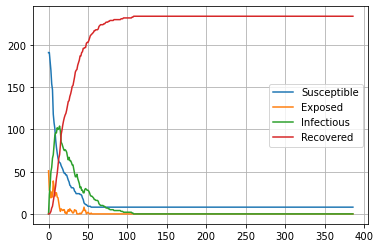

In [33]:
# Now we're plotting things
listPopulations.rename(columns={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}, inplace=True)
listPopulations.plot()
plt.legend()
plt.grid()

No handles with labels found to put in legend.


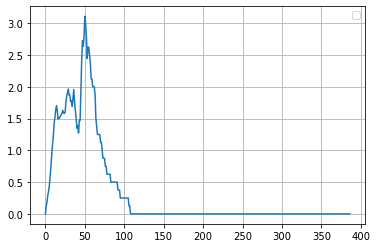

In [34]:
plt.plot (listPopulations['Infectious']/listPopulations['Susceptible'])
plt.legend()
plt.grid()